In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import os
import numpy as np
from PIL import Image

image_files = os.listdir('/kaggle/input/benetech-making-graphs-accessible/train/images/')
dir = '/kaggle/input/benetech-making-graphs-accessible/train/images/'
# read image in a numpy, merge into one larege array, (# of images, size)
#
#

#For Project3 one way I want to improve on this model is by incoperating PCA to make images smaller and model quicker
from sklearn.decomposition import PCA

sorted_image_files = sorted(image_files)

images = []
image_file_names = []

n_components = 0.95
pca1 = PCA(n_components = 0.95)


for i in sorted_image_files:
    image = Image.open(dir + i)
    image = image.convert('L')
    image = image.resize((28, 28)) 
    
    components = pca1.fit_transform(image)
    loadings = pca1.components_
    image_pca = np.matmul(components, loadings)
    
    image_array = np.asarray(image_pca)
    images.append(image_array)
    
    image_file_names.append(os.path.splitext(i)[0])

images = np.array(images)
        

#images = np.concatenate(images)   

images.shape

#read in image, convert to numpy array, resize imamge via pillow to common size (resize), convert to grey scale

(60578, 28, 28)

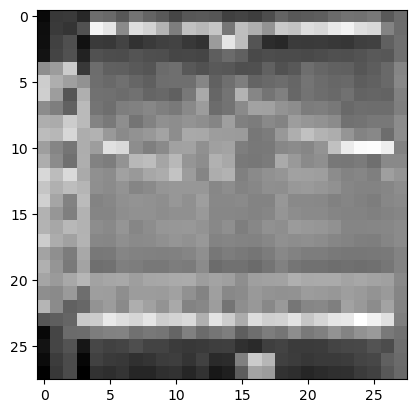

In [3]:
import matplotlib.pyplot as plt

image_look = images[366]
image_look_reshaped = image_look.reshape(28, 28)

plt.imshow(image_look_reshaped, cmap='gray')
plt.show()

In [4]:
import json
import os

json_files = os.listdir('/kaggle/input/benetech-making-graphs-accessible/train/annotations/')
dir_json = '/kaggle/input/benetech-making-graphs-accessible/train/annotations/'

sorted_json_files = sorted(json_files)
chart_class = []


#for j in sorted_json_files:
#    with open(dir_json + j, 'r') as file:
#        json_data = json.load(file)
#        chart_type = json_data['chart-type']
#        chart_class.append(chart_type)


for file_name in image_file_names:
    with open(dir_json + file_name + '.json', 'r') as file:
        json_data = json.load(file)
        chart_type = json_data['chart-type']
        chart_class.append(chart_type)

#print(chart_class)



In [5]:
from scipy.ndimage.interpolation import shift
import random


def shift_image(image, flip_prob=0.05):

    # Random flips
    if np.random.random() < flip_prob:
        flipped_type = random.choice(["horizontal", "vertical"])
        
        if flipped_type == "horizontal":
            shifted_image = np.fliplr(image)
        elif flipped_type == "vertical":
            shifted_image = np.flipud(image)

    # Random rotations
    rotation_angle = random.choice([0, 90, 180, 270])
    shifted_image = np.rot90(image, k=rotation_angle // 90)

    return shifted_image.reshape([28, 28, 1])

In [6]:
import os
import numpy as np
from PIL import Image
from functools import partial
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf


In [62]:
#split into traing and testing, 20%

X = images / 255.0
y = LabelEncoder().fit_transform(chart_class)
#y = chart_class

#########################
#project 3, apply kmenas before input into CNN model. This will aloow for simpler CNN model and less compute power

#n_clusters = 5
#kmeans = KMeans(n_clusters=n_clusters, n_init = 10, random_state=42)
#y_kmeans = kmeans.fit_predict(y.reshape(-1, 1))
#kmeans how no effect on the classification. It really does not make a wole lot of sense to use 
#Kmeans as its unsupervised when we are making a supervised model

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

#data augmentation - project3
X_train_augmented = np.array([shift_image(image) for image in X_train])

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



DefaultConv2D = partial(tf.keras.layers.Conv2D,
                       kernel_size = 3,
                       padding = 'same',
                       activation = 'relu',
                       kernel_initializer = 'he_normal')

#large most complex model
model1 = tf.keras.Sequential([
    DefaultConv2D(filters = 64, kernel_size = 7, input_shape = [28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters = 128),
    DefaultConv2D(filters = 128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters = 256),
    DefaultConv2D(filters = 256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 128, activation = 'relu', kernel_initializer = 'he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units = 64,  activation = 'relu', kernel_initializer = 'he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation = 'softmax')
])

#mid model with 2 layers
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal', input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

#simple model with 1 layer
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal', input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [63]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

#model1.compile(loss = 'sparse_categorical_crossentropy',optimizer = optimizer,metrics = ['accuracy'])
#model2.compile(loss = 'sparse_categorical_crossentropy',optimizer = optimizer,metrics = ['accuracy'])
model3.compile(loss = 'sparse_categorical_crossentropy',optimizer = optimizer,metrics = ['accuracy'])

In [64]:
import time
start_time = time.time()

epochs = 5
#history1 = model1.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val))
#history2 = model2.fit(X_train_augmented, y_train, epochs=epochs, validation_data=(X_val, y_val))
history3 = model3.fit(X_train_augmented, y_train, epochs=epochs, validation_data=(X_val, y_val))


end_time = time.time()
total_time = end_time - start_time
print(f"Compute Time {total_time:.2f} seconds")

#@ 5 epochs
#model1 time: Compute Time 59.02 seconds
#modle2 time: Compute Time 38.43 seconds
#model3 time: Compute Time 41.97 seconds


Epoch 1/5
1515/1515 [==============================] - 7s 4ms/step - loss: 0.4485 - accuracy: 0.8289 - val_loss: 0.2122 - val_accuracy: 0.9279
Epoch 2/5
1515/1515 [==============================] - 6s 4ms/step - loss: 0.2525 - accuracy: 0.9076 - val_loss: 0.1411 - val_accuracy: 0.9536
Epoch 3/5
1515/1515 [==============================] - 6s 4ms/step - loss: 0.1902 - accuracy: 0.9318 - val_loss: 0.1138 - val_accuracy: 0.9640
Epoch 4/5
1515/1515 [==============================] - 6s 4ms/step - loss: 0.1595 - accuracy: 0.9416 - val_loss: 0.1057 - val_accuracy: 0.9663
Epoch 5/5
1515/1515 [==============================] - 6s 4ms/step - loss: 0.1372 - accuracy: 0.9513 - val_loss: 0.0939 - val_accuracy: 0.9703
Compute Time 42.07 seconds


In [11]:
#model1.summary()
#model2.summary()
#model3.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_3 (Dense)             (None, 64)               

<AxesSubplot:>

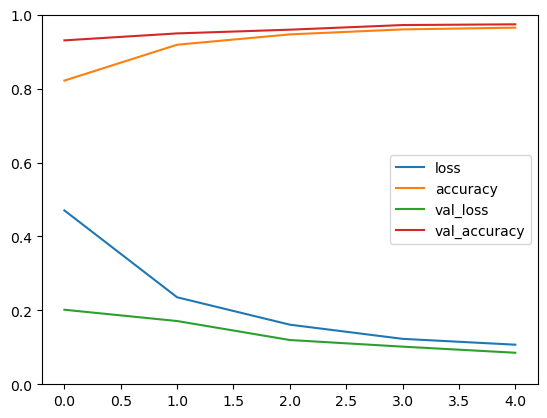

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(ylim = [0,1])

In [65]:
#model1.evaluate(X_test, y_test)
#model2.evaluate(X_test, y_test)
model3.evaluate(X_test, y_test)

#model1 @ [0.03695782646536827, 0.9899306893348694]
#model2 @ [0.023419078439474106, 0.9943050742149353]
#model3 @ [0.034081749618053436, 0.9904258847236633]

#model2 @ [0.03602200374007225, 0.9887751936912537] with data augmentation

379/379 [==============================] - 1s 3ms/step - loss: 0.0924 - accuracy: 0.9695


[0.0923566073179245, 0.9695444107055664]

In [66]:
#######################
#Project 3 part
# I wnt to look into the miss-classifications

#y_pred1 = model1.predict(X_test)
#y_pred2 = model2.predict(X_test)
y_pred3 = model3.predict(X_test)

#y_pred_classes1 = np.argmax(y_pred1, axis=1)
#y_pred_classes2 = np.argmax(y_pred2, axis=1)
y_pred_classes3 = np.argmax(y_pred3, axis=1)

#misclassified_indices = np.where(y_pred_classes1 != y_test)[0]
#misclassified_indices = np.where(y_pred_classes2 != y_test)[0]
misclassified_indices = np.where(y_pred_classes3 != y_test)[0]

379/379 [==============================] - 1s 2ms/step


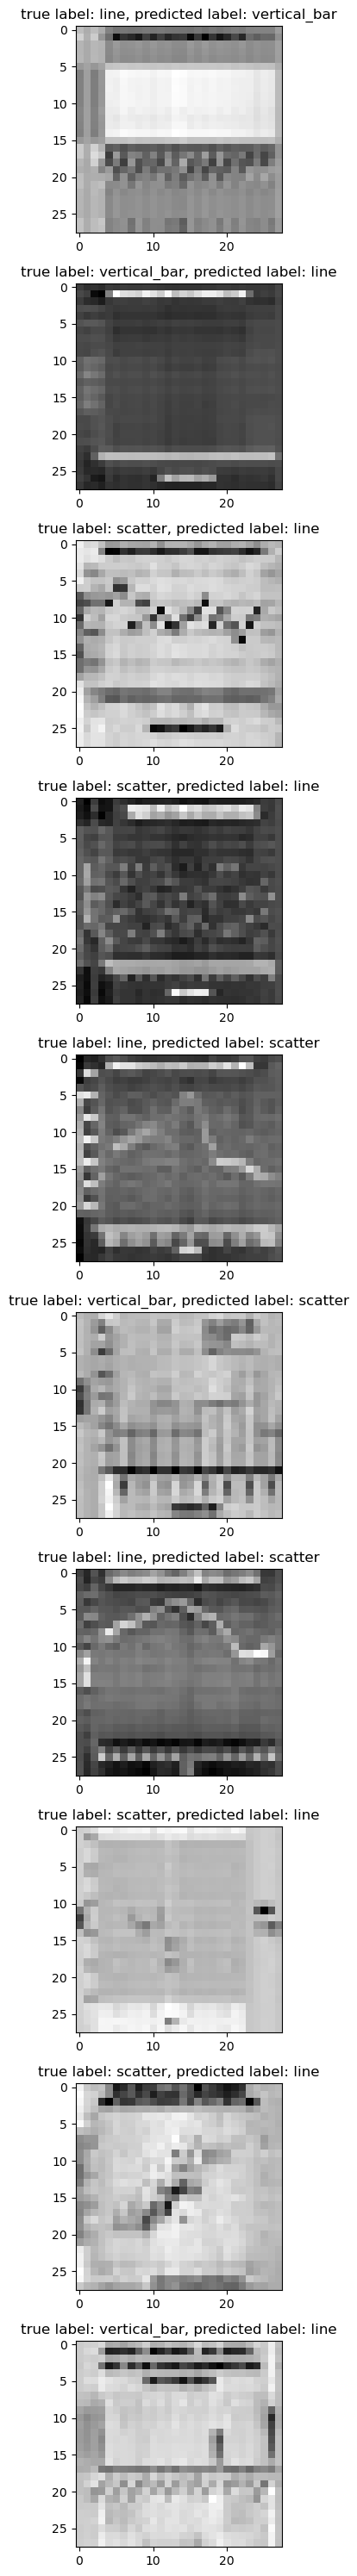

In [67]:
import matplotlib.pyplot as plt

n_show = 10

fig, axes = plt.subplots(n_show, figsize=(10, 30))

#converts the num labels for classificaiton back into type of graph
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(chart_class)

for i, index in enumerate(misclassified_indices[:n_show]):
    ax = axes[i]
    ax.imshow(X_test[index].reshape(28, 28), cmap='gray')
    
    true_label = label_encoder.inverse_transform([y_test[index]])[0]
    pred_label = label_encoder.inverse_transform([y_pred_classes3[index]])[0]
    
    ax.set_title(f"true label: {true_label}, predicted label: {pred_label}")

plt.tight_layout()
plt.show()

In [69]:
from collections import Counter

y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_classes_decoded = label_encoder.inverse_transform(y_pred_classes3)

misclassified_counts = Counter()

for index in range(len(y_test_decoded)):
    if y_test_decoded[index] != y_pred_classes_decoded[index]:
        misclassified_counts[y_test_decoded[index]] += 1

print("Misclassified counts:")
for chart_type, count in misclassified_counts.items():
    print(f"{chart_type}: {count}")
    
#what they were misss classified as, chart with correct classification woud be dignoal. 

Misclassified counts:
line: 110
vertical_bar: 190
scatter: 56
horizontal_bar: 11
dot: 2


In [70]:
#confusion_matrix1 = confusion_matrix(y_test, y_pred_classes1)
#confusion_matrix2 = confusion_matrix(y_test, y_pred_classes2)
confusion_matrix3 = confusion_matrix(y_test, y_pred_classes3)

#print("Confusion Matrix for Model 1:\n", confusion_matrix1)
#print("Confusion Matrix for Model 2:\n", confusion_matrix2)
print("Confusion Matrix for Model 3:\n", confusion_matrix3)

Confusion Matrix for Model 3:
 [[1048    0    0    0    2]
 [   2    1    0    1    8]
 [   2    0 4875   75   33]
 [   0    0   55 2109    1]
 [  10    0  164   16 3714]]


In [73]:
from sklearn.metrics import confusion_matrix

# Confusion matrix for model1
#confusion_matrix1 = confusion_matrix(y_test, y_pred_classes1)

# Confusion matrix for model2
#confusion_matrix2 = confusion_matrix(y_test, y_pred_classes2)

# Confusion matrix for model3
confusion_matrix3 = confusion_matrix(y_test, y_pred_classes3)

chart_types = sorted(set(y_test_decoded))


df_model1 = pd.DataFrame(confusion_matrix1, index=chart_types, columns=chart_types)
df_model2 = pd.DataFrame(confusion_matrix2, index=chart_types, columns=chart_types)
df_model3 = pd.DataFrame(confusion_matrix3, index=chart_types, columns=chart_types)
dfs = [df_model1, df_model2, df_model3]

print(df_model1)
print(df_model2)
print(df_model3)

                 dot  horizontal_bar  line  scatter  vertical_bar
dot             1043               0     0        0             7
horizontal_bar     0              10     2        0             0
line               0               1  4869       21            94
scatter            0               0    24     2141             0
vertical_bar       3               0    11        1          3889
                 dot  horizontal_bar  line  scatter  vertical_bar
dot             1031               0     0        0            19
horizontal_bar     0               2     0        1             9
line               0               0  4869       33            83
scatter            0               0    75     2085             5
vertical_bar       0               0    61        3          3840
                 dot  horizontal_bar  line  scatter  vertical_bar
dot             1048               0     0        0             2
horizontal_bar     2               1     0        1             8
line      

In [74]:
from IPython.display import display, HTML

def display(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display(HTML(html_str))

display_side_by_side(*dfs)

#The rows represent the true labels of the data points.
#The columns represent the predicted labels from the model.
#https://www.geeksforgeeks.org/how-to-render-pandas-dataframe-as-html-table/

,dot,horizontal_bar,line,scatter,vertical_bar
dot,1043,0,0,0,7
horizontal_bar,0,10,2,0,0
line,0,1,4869,21,94
scatter,0,0,24,2141,0
vertical_bar,3,0,11,1,3889
,dot,horizontal_bar,line,scatter,vertical_bar
dot,1031,0,0,0,19
horizontal_bar,0,2,0,1,9
line,0,0,4869,33,83
scatter,0,0,75,2085,5


for model 1 and 2 

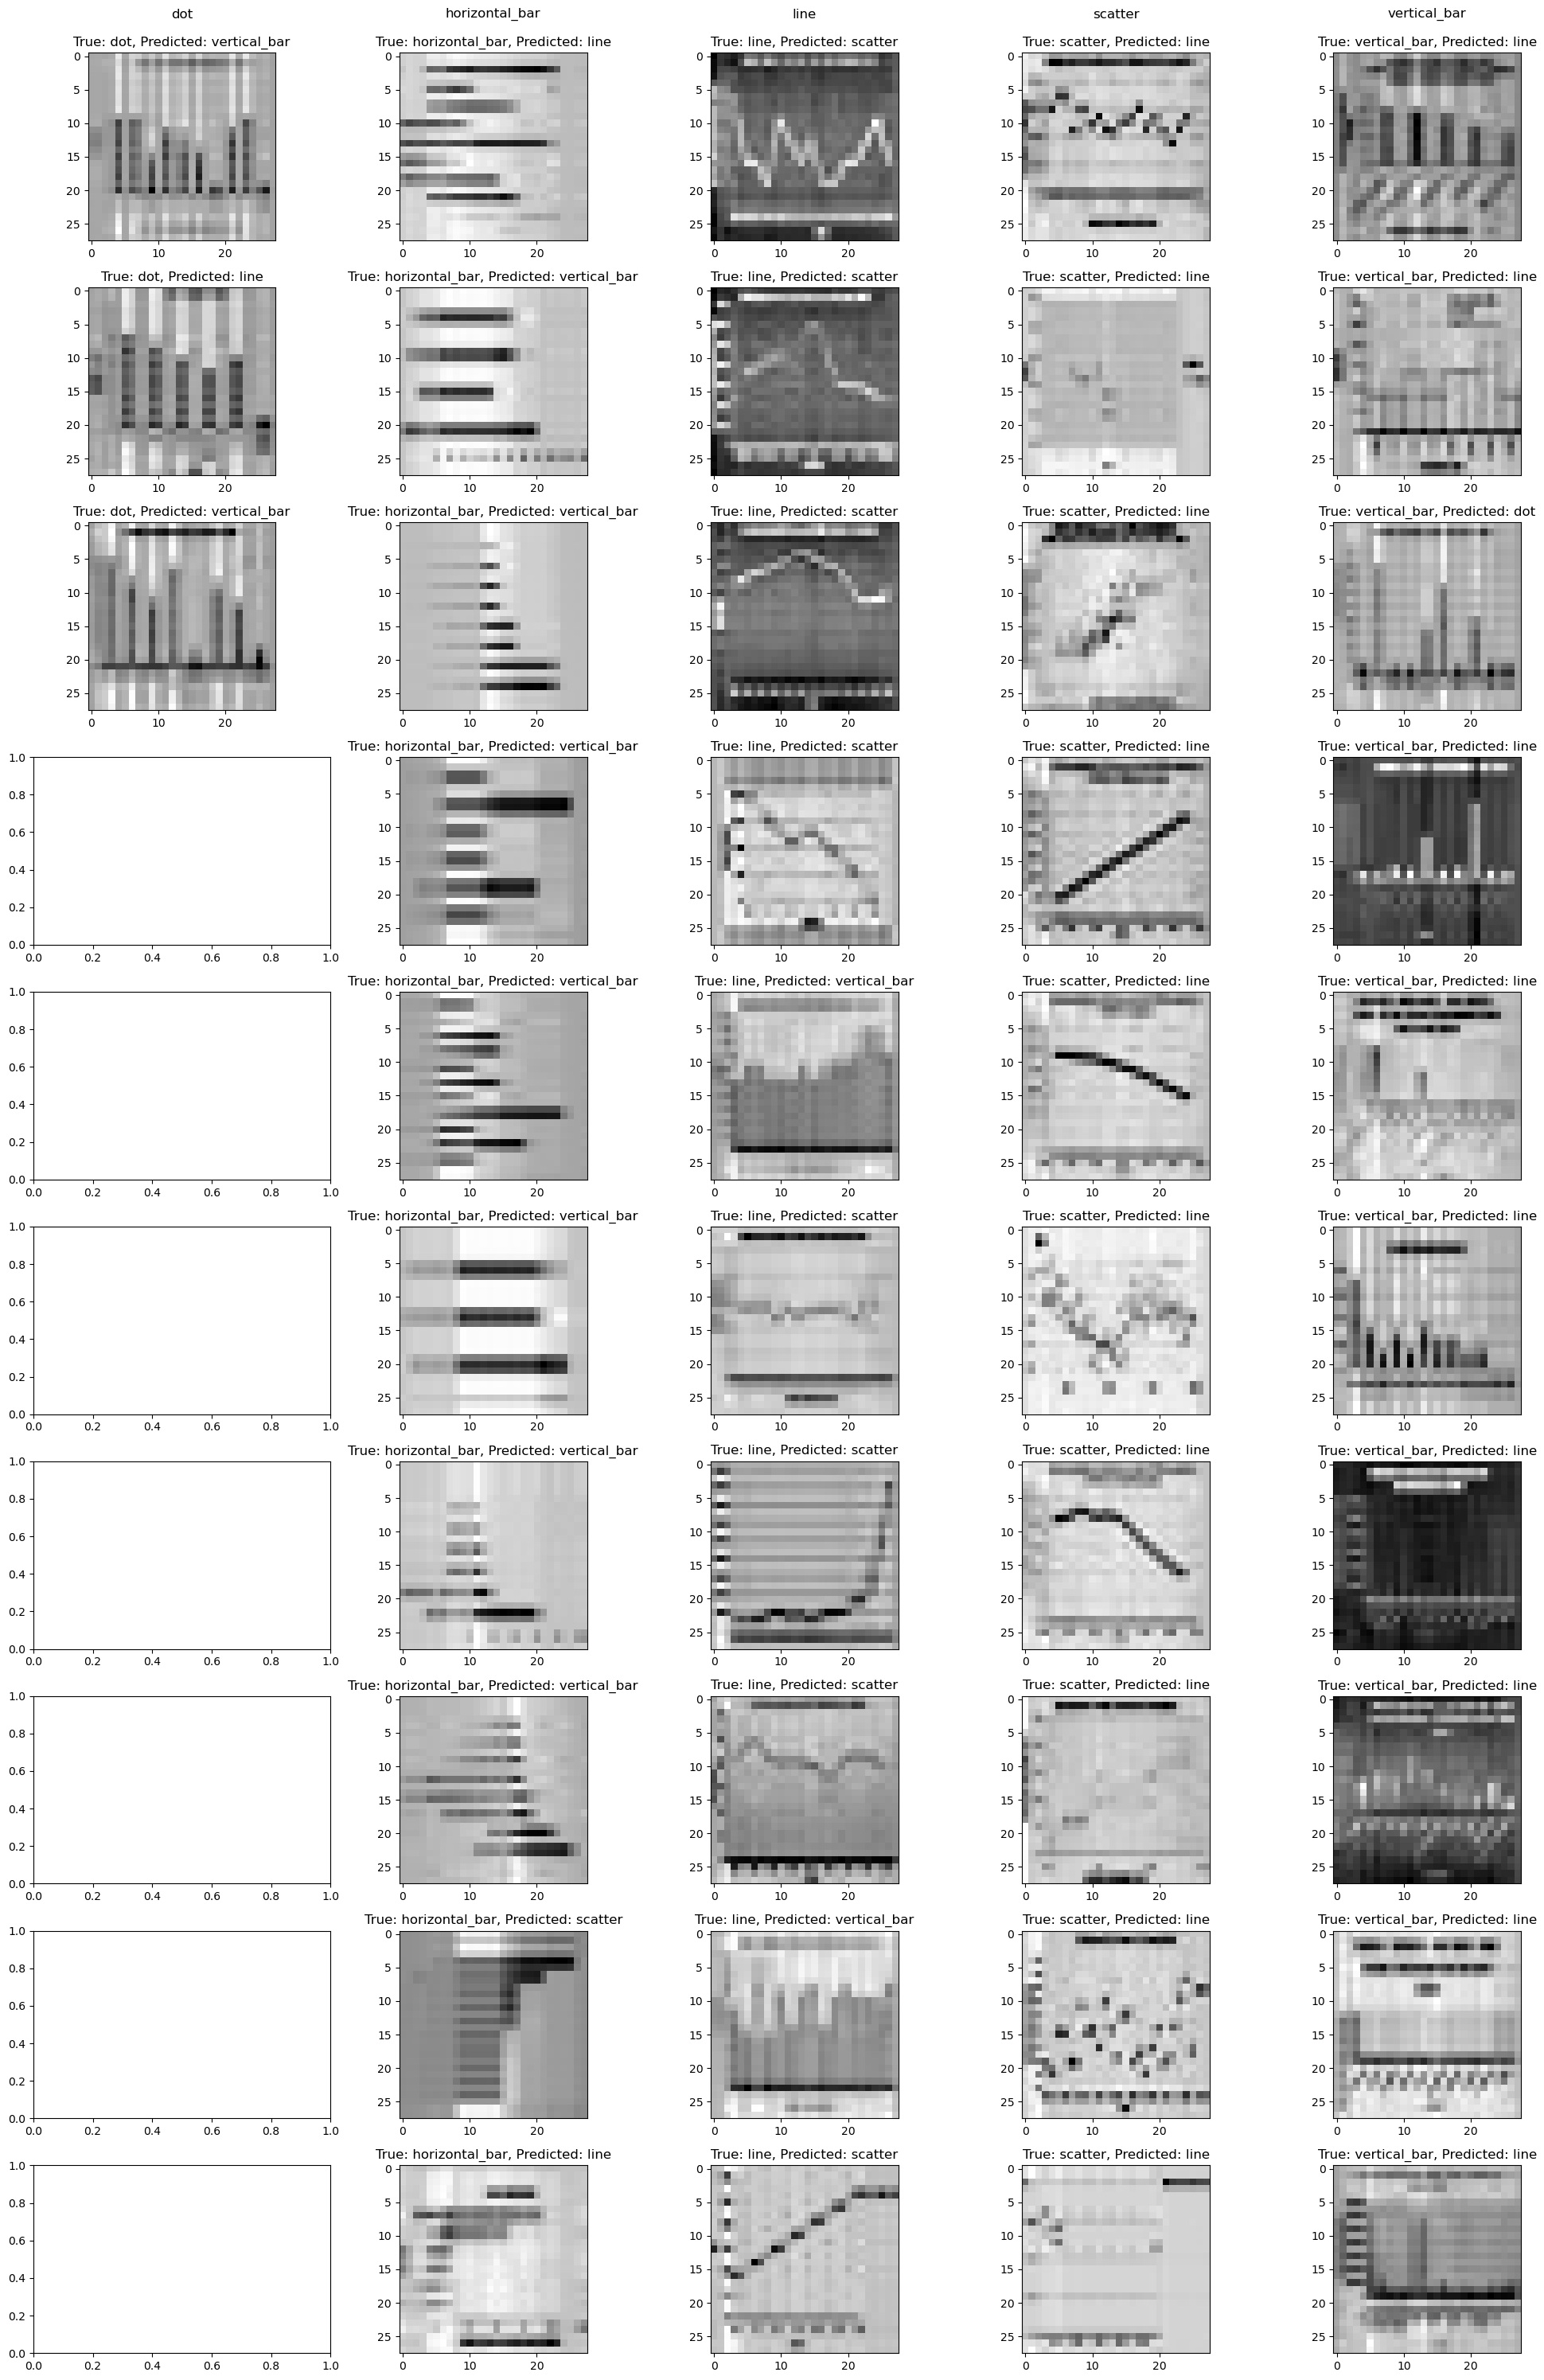

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 42.4 MB/s eta 0:00:0000:010:01


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  This is separate from the ipykernel package so we can avoid doing imports until


Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__'
 * Debug mode: on


Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 1040, in launch_instance
    app.initialize(argv)
  File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 113, in inner
    return method(app, *args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 666, in initialize
    self.init_sockets()
  File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 307, in init_sockets
    self.shell_port = self._bind_socket(self.shell_socket, self.shell_port)
  File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 244, in _bind_socket
    return self._try_bind_socket(s, port)
  File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 220, in _try_bind_socket
    s.bind("tcp://%s:%i" % (sel

SystemExit: 1

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


**Write a two-paragraph summary of your model and results below:**

Our model is a deep convolutional neural network (CNN) built using TensorFlow Keras, inspired by the "Hands-On Machine Learning" textbook example. The architecture consists of several layers, including Conv2D layers with 64, 128, and 256 filters, Max Pooling layers, Dense Layers with 128 and 64 units, and an output layer with 10 units and SoftMax activation for multiclass classification. We utilized the sparse_categorical_crossentropy loss function and accuracy metrics during training, and an Adam optimizer with a learning rate of 0.001 to improve the model's performance. We also experimented with the number of epochs, finding that having 10 epochs was an ample amount that reached convergence but did not overfit the model. Using the Kaggle external GPU T4 x2, each epoch was able to run in roughly 12 seconds, leading to a total compute time of 2 minutes. The model achieved an accuracy of approximately 98.14% on the test dataset with a loss of about 0.0550. This suggests that the model is able to generalize well and can accurately classify graph types given an image of a graph.

To further improve the model, we could explore several options. One approach is to look into simplifying the model without compromising accuracy. Another option is to experiment with different learning rates and investigate their impact on performance. We could also consider ways to reduce computational power and increase computational speed, such as by optimizing the model for hardware acceleration or utilizing more efficient algorithms. Additionally, we could analyze the misclassifications to identify any common characteristics that may have led to incorrect predictions. Overall, our model achieved excellent results, but there are always opportunities for further optimization and refinement.

Write a two-paragraph summary of your model and results below.  Specifically, you should address the following:

**The architecture of your model**

Our model is a deep convolutional neural network (CNN) built using TensorFlow Keras, inspired by the "Hands-On Machine Learning" textbook example. The architecture consists of the following layers:

Input layer: A Conv2D layer with 64 filters, kernel size of 7, and input shape of [28, 28, 1].
Max Pooling layers.
Conv2D layers with 128 filters.
Conv2D layers with 256 filters.
Flatten Layer.
Dense Layer: 128 units, ReLU Activation.
Dropout layers separating dense layers.
Dense Layers: 64 units, ReLU Activation.
Output Layer: Dense Layers with 10 units and SoftMax Activation for multiclass classification.


All Conv2D layers have the same padding, activation, and kernel_initializer settings, defined in the DefaultConv2D function.

--------------------------------------------------

**hyperparameter values (optimizer, learning rate, activation function, etc.)**

The hyperparameter values used for the model include an Adam optimizer with a learning rate of 0.001. The Adam optimizer uses a variable learning rate for each parameter during training, leading to faster convergence and improved performance. The learning rate of 0.001 was chosen as a default value for the optimizer; this value could be experimented with to further refine and optimize the model to find the best fit. For the model, we chose a ReLU activation function for all Conv2D and Dense layers due to its simplicity and speed at which the model can fit to the data. For the output layer's activation function, we chose the softmax activation function because of its ability for multiclass classification. Softmax outputs probabilities where the sum will equal 1, allowing for easy interpretability in which class the model is predicting the input image to be. To measure loss, we utilized the sparse_categorical_crossentropy as the loss function. This loss function works well with multiclass classification problems where a softmax output function is used. Other metrics we used were accuracy, which takes the ratio of correctly classified instances to the total number of instances. 

--------------------------------------------------

**training (how many epochs, runtime, etc.)**

For this model, we ran three tests, each having a different number of epochs ranging from 5, 10, 15. After the three tests, we found that having 10 epochs was an ample amount that reached convergence but did not overfit the model. The result was roughly a 0.985 accuracy with less than 0.05 loss.

Utilizing the Kaggle external GPU T4 x2, each epoch was able to run in roughly 12 seconds, leading to a total compute time of 2 minutes. Possible ways to reduce this runtime would be to make the CNN simpler, with the trade-off being accuracy; however, there may be methods to simplify the model without losing performance.

The training and validation (X_val, y_val) were used to evaluate the model's performance during training while still using a 20% testing split. The main thing we watched for within the training set was the loss and accuracy where the performance on the validation dataset was degrading while the training performance was still improving, which would be a sign of overfitting.

--------------------------------------------------


**performance on your validation set**

The model achieved an accuracy of approximately 98.71% on the test dataset. The loss was about 0.0483. This suggests that the model is able to generalize well and can accurately classify graph types given an image of a graph. To further improve the model, we might look at making the model simpler while keeping similar accuracy levels, taking a look at computational power, increasing computational speed, as well as looking into different learning rates. We could also gather the misclassifications and try to see if there are any common characteristics that would possibly lead to the misclassification



